In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import scipy.sparse
import tensorflow_hub as hub
import pickle
from tqdm import tqdm
from sklearn import utils
import multiprocessing
from nltk.tokenize import word_tokenize
import json
import numpy as np
import scipy.sparse
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
import pickle
import tensorflow_hub as hub
import pickle
import matplotlib.pyplot as plt
import json
from sklearn.pipeline import Pipeline, TransformerMixin

## Read Inputs

In [2]:
texts = pd.read_csv("preprocessed_texts.csv")
labels = np.load("preprocessed_labels.npy", allow_pickle = True)
texts = texts.assign(label = labels)

## Transformation

Configuration for Transformation

In [3]:
# TF-IDF | CountVectorization | BERT | DOC2VEC
method = "TF-IDF"
dimension = 200 # Doc2Vec vector dimension
epochs = 10 # Doc2Vec training epochs
min_df = 0.001 # TF-IDF min df
max_df = 0.9 # TF-IDF max df
use_idf = False
outer_splits = 5
inner_splits = 5
random_iterations = 10
param_grid = {
    "logistic__C": list(np.logspace(-3,3,4)), 
    "logistic__penalty": ["l2"],
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    "doc2vec__doc_vec_transformer__kw_args": [{"dimension": 50}, {"dimension": 200}],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    "svm__C": [1, 10, 100, 1000], 
    "svm__gamma": [.001, .01, .1, 1]
    }

with open('config.json', 'r') as openfile:
    json_object = json.load(openfile)
    json_object["transformation_method"] = method
    json_object["doc2vec_dimension"] = dimension
    json_object["doc2vec_epochs"] = epochs
    json_object["min_df"] = min_df
    json_object["max_df"] = max_df
    json_object["use_idf"] = use_idf
    json_object["outer_splits"] = outer_splits
    json_object["innter_splits"] = inner_splits
    json_object["param_grid"] = param_grid
with open("config.json", "w") as outfile:
    outfile.write(json.dumps(json_object))

#### Count Vectorization
We cannot use this vectorization methods because the fake news differ in the length of texts from the true news

In [7]:
if method == "CountVectorization":
    vectorizer = CountVectorizer(analyzer="word")
    all_tokens = vectorizer.fit_transform(texts)

#### TF-IDF Vectorization

In [4]:
inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer()

In [6]:
logistic_grid = {
    "logistic__C": [0.01, 0.1, 10], 
    "logistic__penalty": ["l2"],
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    }
pipeline = Pipeline([("vectorizer", vectorizer), ("logistic", LogisticRegression(max_iter=10000))])
clf = GridSearchCV(pipeline, logistic_grid, cv=inner_cv, n_jobs=-1, verbose=4)
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts["text"]):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts["text"][train_index], texts["text"][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

CV run 1
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best model:
Accuracy: 0.930675345648768
{'bayes__alpha': 0.01, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 0.001, 'vectorizer__use_idf': False}
Test Accuracy: 0.9288418708240535
Test F1: 0.9237379162191192
Test AUC: 0.9279377232563611
Test precision: 0.9365924491771539
Test recall: 0.9112314574994114
[[4471  262]
 [ 377 3870]]
CV run 2
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best model:
Accuracy: 0.9296730370861417
{'bayes__alpha': 0.01, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0.001, 'vectorizer__use_idf': False}
Test Accuracy: 0.9314031180400891
Test F1: 0.9272211720226843
Test AUC: 0.9306735835190695
Test precision: 0.9407815871493647
Test recall: 0.9140461215932913
[[4440  247]
 [ 369 3924]]
CV run 3
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fit

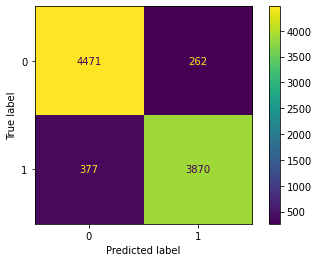

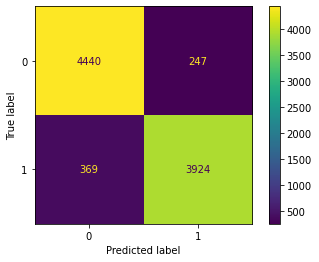

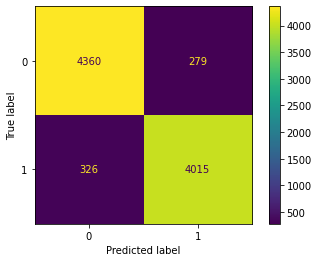

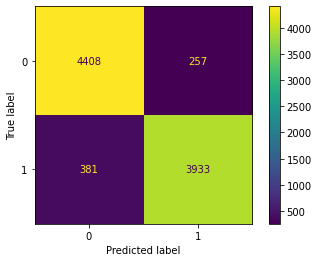

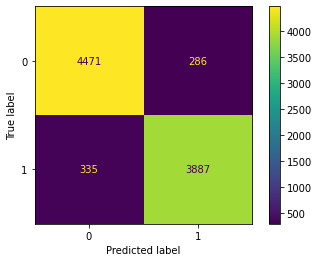

In [11]:
bayes_grid = {
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    }
pipeline = Pipeline([("vectorizer", vectorizer), ("bayes", MultinomialNB())])
clf = GridSearchCV(pipeline, bayes_grid, cv=inner_cv, n_jobs=-1, verbose=4)
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts["text"]):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts["text"][train_index], texts["text"][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

In [7]:
pipeline = Pipeline([("vectorizer", vectorizer), ("svm", SVC(kernel="rbf"))])
pipeline.fit(X=texts["text"], y=labels)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('svm', SVC())])

In [58]:
from sklearn.model_selection import train_test_split
pipeline = Pipeline([("vectorizer", vectorizer), ("svm", SVC(kernel="rbf"))])
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    train, test = texts.iloc[train_index], texts.iloc[test_index]
    grid_train, grid_test = train_test_split(train, test_size=0.5, shuffle=True)
    reduced_training = grid_train.iloc[0:2000]
    best_idf = False
    best_min_df = 0
    best_max_df = 0
    best_c = 0
    best_gamma = 0
    best_accuracy = 0
    for idf in [True, False]:
        print(f"IDF: {idf}")
        for min_df in [0.001, 0.01]:
            print(f"min df {min_df}")
            for max_df in [0.5, 0.7]:
                print(f"max_df {max_df}")
                vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, use_idf=idf)
                grid_train_vectorized = vectorizer.fit_transform(reduced_training["text"])
                grid_test_vectorized = vectorizer.transform(grid_test["text"])
                for c in [1, 10, 100]:
                    print(f"C {c}")
                    for gamma in [.01, .1, 1]:
                        print(f"gamma {gamma}")
                        clf = SVC(C=c, gamma=gamma)
                        clf.fit(grid_train_vectorized, reduced_training["label"])
                        predictions = clf.predict(grid_test_vectorized)
                        accuracy = accuracy_score(grid_test["label"], predictions)
                        print(f"Accuracy: {accuracy}")
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_idf = idf
                            best_min_df = min_df
                            best_max_df = max_df
                            best_c = c
                            best_gamma = gamma
    # Refit the classifier
    print("Perform Grid Search")
    vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df, use_idf=best_idf)
    train_vectorized = vectorizer.fit_transform(train["text"])
    test_vectorized = vectorizer.transform(test["text"])
    print(f"Best model: idf {best_idf}, min_df {best_min_df}, max_df {best_max_df}, c {best_c}, gamma {best_gamma}")
    clf = SVC(C=best_c, gamma=best_gamma)
    clf.fit(train_vectorized, train["label"])
    predictions = clf.predict(test_vectorized)
    accuracy = accuracy_score(test["label"], predictions)
    f1 = f1_score(test["label"], predictions, average="binary")
    auroc = roc_auc_score(test["label"], predictions)
    precision = precision_score(test["label"], predictions)
    recall = recall_score(test["label"], predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(test["label"], predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
IDF: True
min df 0.001
max_df 0.5
C 1
0.5244167269892533
0.9264435659001058
0.9388050559607996
C 10
0.9295060972214488
0.9469346845592739
0.9435380589119662
C 100
0.9468790021716131
0.9477699203741856
0.9435380589119662
max_df 0.7
C 1
0.5243610446015925
0.9264992482877665
0.9398630213263545
C 10
0.9299515563227351
0.9481596970878111
0.9436494236872877
C 100
0.9482153794754719
0.9482153794754719
0.9436494236872877
min df 0.01
max_df 0.5
C 1
0.591681051283479
0.9269447073890529
0.9382482320841917
C 10
0.9293947324461272
0.943315329361323
0.9437051060749485
C 100
0.9418675872821427
0.9418119048944819
0.9437051060749485
max_df 0.7
C 1
0.5878946489225458
0.9273901664903391
0.9385823264101565
C 10
0.9297845091597527
0.9439835180132524
0.9439278356255916
C 100
0.9431482821983407
0.9431482821983407
0.9439278356255916
IDF: False
min df 0.001
max_df 0.5
C 1


#### BERT

In [66]:
if method == "BERT":
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

    print(f'BERT model selected           : {tfhub_handle_encoder}')
    print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

    
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    #if "OSError: SavedModel file does not exist" occurs, navigate to the indicated folder and delete it
    
    text_test = texts
    text_preprocessed = bert_preprocess_model(text_test)

    #print(text_test)
    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
    print(f'Input Mask : {text_preprocessed["input_mask"]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

#### DOC2Vec
Converting the document into vectors

In [9]:
class DocVecTransformer(TransformerMixin):
    def __init__(self, dimension = 50):
        print(f"Doc2Vec Dimension {dimension}.")
        self.dimension = dimension

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):  
        print("Started")          
        tagged_texts = []
        for i, text in enumerate(X):
                word_tokens = word_tokenize(text)
                tagged_texts.append(TaggedDocument(word_tokens, [i]))
        cores = multiprocessing.cpu_count()

        model = Doc2Vec(dm=0, vector_size=self.dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        model.build_vocab([x for x in tqdm(tagged_texts)])
        for epoch in range(epochs):
            model.train(utils.shuffle([x for x in tqdm(tagged_texts)]), total_examples=len(tagged_texts), epochs=1)
            model.alpha -= 0.002
            model.min_alpha = model.alpha
        vector_list = []
        for i in range(len(X)):
            vector_list.append(model.dv[i])
        print("Doc2Vec finished")
        return scipy.sparse.csr_matrix(vector_list)

In [13]:
import nltk
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [29]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [50]:
import multiprocessing
cores = multiprocessing.cpu_count()
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    outer_train = texts[["text", "label"]].iloc[train_index]
    outer_test = texts[["text", "label"]].iloc[test_index]
    best_accuracy = 0
    best_c = 0
    best_dimension = 0
    inner_train, inner_test = train_test_split(outer_train)
    for dimension in [50,500, 1000]:
        print(f"Dimension: {dimension}")
        model_dbow = Doc2Vec(dm=0, vector_size=dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        train_tagged = inner_train.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        test_tagged = inner_test.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        model_dbow.build_vocab([x for x in train_tagged.values])
        model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)
        inner_y_train, inner_X_train = vec_for_learning(model_dbow, train_tagged)
        inner_y_test, inner_X_test = vec_for_learning(model_dbow, test_tagged)
        for c in np.logspace(-3, 3, 6):
            print(f"C: {c}")
            clf = LogisticRegression(max_iter=10000, C=c)
            clf.fit(inner_X_train, inner_y_train)
            predictions = clf.predict(inner_X_test)
            accuracy = accuracy_score(inner_y_test, predictions)
            print(f"Model accuracy: {accuracy}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_c = c
                best_dimension = dimension
    model_dbow = Doc2Vec(dm=0, vector_size=best_dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    train_tagged = outer_train.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    test_tagged = outer_test.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=30)
    outer_y_train, outer_X_train = vec_for_learning(model_dbow, train_tagged)
    outer_y_test, outer_X_test = vec_for_learning(model_dbow, test_tagged)
    clf = LogisticRegression(max_iter=10000, C=best_c)
    clf.fit(outer_X_train, outer_y_train)
    predictions = clf.predict(outer_X_test)
    print(f"Best model: dimension {best_dimension}, c {best_c}")
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
Dimension: 50
C: 0.001
Model accuracy: 0.9741648106904232
C: 0.015848931924611134
Model accuracy: 0.9780623608017818
C: 0.25118864315095796
Model accuracy: 0.9778396436525613
C: 3.981071705534969
Model accuracy: 0.977728285077951
C: 63.0957344480193
Model accuracy: 0.977728285077951
C: 1000.0
Model accuracy: 0.977728285077951
Dimension: 500
C: 0.001
Model accuracy: 0.9826280623608018
C: 0.015848931924611134
Model accuracy: 0.9870824053452116
C: 0.25118864315095796
Model accuracy: 0.9876391982182628
C: 3.981071705534969
Model accuracy: 0.9856347438752784
C: 63.0957344480193
Model accuracy: 0.9858574610244989
C: 1000.0
Model accuracy: 0.9859688195991091
Dimension: 1000
C: 0.001
Model accuracy: 0.9835189309576837
C: 0.015848931924611134
Model accuracy: 0.9878619153674832
C: 0.25118864315095796
Model accuracy: 0.9881959910913141
C: 3.981071705534969
Model accuracy: 0.9880846325167038
C: 63.0957344480193
Model accuracy: 0.9853006681514477
C: 1000.0
Model accuracy: 0.981403118040089

100%|██████████| 35918/35918 [00:00<00:00, 5130291.54it/s]


KeyboardInterrupt: 

In [ ]:
bayes_grid = {
    "doc2vec__doc_vec_transformer__kw_args": [{"dimension": 50}, {"dimension": 200}],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    }
pipeline = Pipeline([("doc2vec", DocVecTransformer()), ("bayes", MultinomialNB())])
clf = GridSearchCV(pipeline, logistic_grid, cv=inner_cv, n_jobs=-1, verbose=4)
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts["text"]):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts["text"][train_index], texts["text"][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

Doc2Vec Dimension 50.
CV run 1
Get data
Perform Grid Search
Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


# Store Results

In [11]:
if method == "BERT":
    a_file = open("bert_preprocessed.pkl", "wb")
    pickle.dump(text_preprocessed, a_file)
    a_file.close()
    np.save("training_labels", labels)